# Simulated interpolation (Figure 2F)

In [ ]:
%load_ext nb_black

import matplotlib.pyplot as plt
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import adata_query
import larry
import pandas as pd
import numpy as np
import tqdm.notebook
import ABCParse
import autodevice
import torch
import pathlib
import glob

from typing import Tuple

In [1]:
h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)

project_path = "/home/mvinyard/experiments/LARRY.full_dataset/LightningSDE-FixedPotential-RegularizedVelocityRatio"
project = sdq.io.Project(path=project_path)

InterpolationData = larry.tasks.interpolation.InterpolationData
sinkhorn = SinkhornDivergence()
SinkhornDivergence = sdq.core.lightning_models.base.SinkhornDivergence

class InterpolationTask(ABCParse.ABCParse):
    def __init__(
        self,
        adata,
        time_key="Time point",
        use_key="X_pca",
        t0=2,
        n_samples=10_000,
        lineage_key="clone_idx",
        device=autodevice.AutoDevice(),
        backend = "auto",
        silent = False,
        PCA = None,
        *args,
        **kwargs,
    ):
        self.__parse__(locals())

        self.data = InterpolationData(**self._DATA_KWARGS)
                
        self.SinkhornDivergence = SinkhornDivergence(**self._SINKHORN_KWARGS)

    @property
    def _DATA_KWARGS(self):
        return ABCParse.function_kwargs(
            func=InterpolationData, kwargs=self._PARAMS
        )
    @property
    def _SINKHORN_KWARGS(self):
        return ABCParse.function_kwargs(
            func=SinkhornDivergence, kwargs=self._PARAMS
        )

    def forward_without_grad(self, DiffEq):
        """Forward integrate over the model without gradients."""
        with torch.no_grad():
            X_hat = DiffEq.forward(self.data.X0, self.data.t)
            return self._parse_forward_out(X_hat)

    def forward_with_grad(self, DiffEq):
        """Forward integrate over the model retaining gradients."""
        torch.set_grad_enabled(True)
        X_hat = DiffEq.forward(self.data.X0, self.data.t)
        return self._parse_forward_out(X_hat)
    
    @property
    def potential(self):
        return "Potential" in str(self.DiffEq)
    
    def _parse_forward_out(self, X_hat):
        """to account for KLDiv"""
        if isinstance(X_hat, Tuple):
            return X_hat[0]
        return X_hat
    
    def _dimension_reduce_pca(self, X_hat):
        return torch.stack(
            [torch.Tensor(self.PCA.transform(x)) for x in X_hat.detach().cpu().numpy()]
        ).to(self.device)     


    def __call__(self, trainer, DiffEq, *args, **kwargs):
        
        self.__update__(locals())
        
        if self.potential:
            X_hat = self.forward_with_grad(DiffEq)
        else:
            X_hat = self.forward_without_grad(DiffEq)
            
        if not self.PCA is None:
            X_hat = self._dimension_reduce_pca(X_hat)
        
        d4_loss = self.SinkhornDivergence(X_hat[1], self.data.X_test_d4).item()
        d6_loss = self.SinkhornDivergence(X_hat[2], self.data.X_train_d6).item()

        if not self.silent:
            print(
                "- Epoch: {:<5}| Day 4 loss: {:.2f} | Day 6 loss: {:.2f}".format(
                    DiffEq.current_epoch, d4_loss, d6_loss,
                ),
            )

        return d4_loss, d6_loss


AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


In [5]:
class Results:
    def __init__(self, Results):
        self.d2 = pd.DataFrame([result["d2"] for i, result in Results.items()]).T
        self.d4 = pd.DataFrame([result["d4"] for i, result in Results.items()]).T
        self.d6 = pd.DataFrame([result["d6"] for i, result in Results.items()]).T
        self.d2_d4 = pd.DataFrame([result["d2.d4"] for i, result in Results.items()]).T
        self.d4_d6 = pd.DataFrame([result["d4.d6"] for i, result in Results.items()]).T
        self.d2_d6 = pd.DataFrame([result["d2.d6"] for i, result in Results.items()]).T
        self.d2_d2 = pd.DataFrame([result["d2.d2"] for i, result in Results.items()]).T
        self.d4_d4 = pd.DataFrame([result["d4.d4"] for i, result in Results.items()]).T
        self.d6_d6 = pd.DataFrame([result["d6.d6"] for i, result in Results.items()]).T


class PiecewiseDistance(ABCParse.ABCParse):
    def __init__(
        self,
        adata,
        n_samples: int = 10_000,
        t=torch.linspace(2, 6, 41),
        device: torch.device = autodevice.AutoDevice(),
        *args,
        **kwargs,
    ):
        self.__parse__(locals())
        self._df = self._adata.obs.copy()
        self._clonal_df = self._df.loc[self._df["clone_idx"].notna()]

    def sampling(self, group_df, N: int = 10_000):
        if N > group_df.shape[0]:
            replace = True
        else:
            replace = False
        return group_df.sample(N, replace=True).index

    def sample_indices(self, clonal_df):
        print("Call clonal sampling")
        return {
            group: self.sampling(group_df)
            for group, group_df in clonal_df.groupby("Time point")
        }

    @property
    def X2(self):
        if not hasattr(self, "_X2"):
            self._X2 = adata_query.fetch(
                self._adata[self.indices[2]],
                key="X_pca",
                torch=True,
                device=self._device,
            )
        return self._X2

    @property
    def X4(self):
        if not hasattr(self, "_X4"):
            self._X4 = adata_query.fetch(
                self._adata[self.indices[4]],
                key="X_pca",
                torch=True,
                device=self._device,
            )
        return self._X4

    @property
    def X6(self):
        if not hasattr(self, "_X6"):
            self._X6 = adata_query.fetch(
                self._adata[self.indices[6]],
                key="X_pca",
                torch=True,
                device=self._device,
            )
        return self._X6

    @property
    def t(self):
        return self._t.to(self._device)

    def simulate(self, DiffEq):
        return DiffEq.forward(self.X2, t=self.t)

    @property
    def divs(self):
        if not hasattr(self, "_divs"):
            divs = np.linspace(0, self._n_samples, 11).astype(int)
            self._divs = (divs[:-1], divs[1:])
        return self._divs

    @property
    def Z_hat(self):
        if not hasattr(self, "_Z_hat"):
            self._Z_hat = self.simulate(self._DiffEq)
        return self._Z_hat

    def forward(self, XA, XB, *args, **kwargs):
        self.__update__(locals())

        self._distances = []
        div_i, div_j = self.divs
        with torch.no_grad():
            for i, j in zip(div_i, div_j):
                self._distances.append(sinkhorn(XA[i:j], XB[i:j]))
        return torch.stack(self._distances).detach().cpu().mean().item()

    def compute_d2_distance(self):
        return [self.forward(self.Z_hat[i], self.X2) for i in range(len(self.Z_hat))]

    def compute_d4_distance(self):
        return [self.forward(self.Z_hat[i], self.X4) for i in range(len(self.Z_hat))]

    def compute_d6_distance(self):
        return [self.forward(self.Z_hat[i], self.X6) for i in range(len(self.Z_hat))]

    def compute_self_distances(self):

        self.X2_X4 = self.forward(self.X2, self.X4)
        self.X2_X6 = self.forward(self.X2, self.X6)
        self.X4_X6 = self.forward(self.X4, self.X6)

        self.X2_X2 = self.forward(self.X2, self.X2)
        self.X4_X4 = self.forward(self.X4, self.X4)
        self.X6_X6 = self.forward(self.X6, self.X6)

    def compute_d2_d6(self):
        return self.forward(self.X2, self.X6)

    def compute_d4_d4(self):
        return self.forward(self.X2, self.X4)

    def compute_d4_d6(self):
        return self.forward(self.X2, self.X6)

    def __call__(self, DiffEq, N=5):
        self.__update__(locals())

        _Results = {}
        for i in tqdm.notebook.tqdm(range(self._N)):
            self.indices = self.sample_indices(self._clonal_df)
            self.compute_self_distances()
            _Results[i] = {
                "d2": self.compute_d2_distance(),
                "d4": self.compute_d4_distance(),
                "d6": self.compute_d6_distance(),
                "d2.d2": self.X2_X2,
                "d4.d4": self.X4_X4,
                "d6.d6": self.X6_X6,
                "d2.d4": self.X2_X4,
                "d4.d6": self.X4_X6,
                "d2.d6": self.X2_X6,
            }

            del self._X2
            del self._X4
            del self._X6
            del self._Z_hat

        return Results(_Results)

<IPython.core.display.Javascript object>

In [8]:
best_ckpts = sdq_an.parsers.summarize_best_checkpoints(project)

for vname, ckpt_path in best_ckpts["ckpt_path"].items():
    save_path = pathlib.Path(f"sdq.simulate_interpolation.{vname}.pkl")
    if not save_path.exists():
        model = sdq.io.load_model(adata, ckpt_path=ckpt_path)
        pw_distance = PiecewiseDistance(adata)
        version_results = pw_distance(model.DiffEq)
        sdq.io.write_pickle(version_results, save_path)

 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.


  0%|          | 0/5 [00:00<?, ?it/s]

Call clonal sampling
Call clonal sampling
Call clonal sampling
Call clonal sampling
Call clonal sampling


<IPython.core.display.Javascript object>

In [11]:
d2 = pd.DataFrame(
    [
        sdq.io.read_pickle(path).d2.mean(1)
        for path in glob.glob("sdq.simulate_interpolation.*.pkl")
    ]
).T
d4 = pd.DataFrame(
    [
        sdq.io.read_pickle(path).d4.mean(1)
        for path in glob.glob("sdq.simulate_interpolation.*.pkl")
    ]
).T
d6 = pd.DataFrame(
    [
        sdq.io.read_pickle(path).d6.mean(1)
        for path in glob.glob("sdq.simulate_interpolation.*.pkl")
    ]
).T
d2_d6 = pd.DataFrame(
    [
        sdq.io.read_pickle(path).d2_d6.mean(1)
        for path in glob.glob("sdq.simulate_interpolation.*.pkl")
    ]
).mean()[0]
d2_d4 = pd.DataFrame(
    [
        sdq.io.read_pickle(path).d2_d4.mean(1)
        for path in glob.glob("sdq.simulate_interpolation.*.pkl")
    ]
).mean()[0]

<IPython.core.display.Javascript object>

In [12]:
import cellplots as cp

<IPython.core.display.Javascript object>

In [13]:
time_cmap = sdq_an.pl.TimeColorMap()()

<IPython.core.display.Javascript object>

In [14]:
len(time_cmap)

41

<IPython.core.display.Javascript object>

In [22]:
colors = [time_cmap[4], time_cmap[20], time_cmap[40]]

<IPython.core.display.Javascript object>

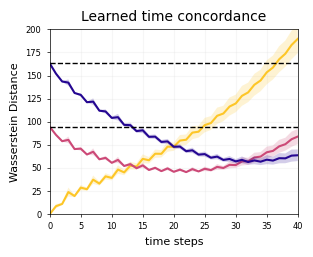

<IPython.core.display.Javascript object>

In [35]:
fig, axes = cp.plot(
    1,
    1,
    height=0.5,
    width=0.5,
    x_label=["time steps"],
    y_label=["Wasserstein Distance"],
    title=["Learned time concordance"],
)
ax = axes[0]
for en, d in enumerate([d2, d4, d6]):
    mean = d.mean(1)
    std = d.std(1)
    lo = mean - std
    hi = mean + std

    ax.fill_between(
        mean.index, lo, hi, color=colors[en], alpha=0.2, ec="None", zorder=2
    )
    ax.plot(mean, color=colors[en])
ax.hlines(d2_d6, 0, 40, lw=1, color="k", ls="--", zorder=3)
ax.hlines(d2_d4, 0, 40, lw=1, color="k", ls="--", zorder=3)
ax.grid(True, alpha=0.2, c="lightgrey")
ax.set_ylim(0, 200)
ax.set_xlim(0, 40)
ax.tick_params(axis="both", width=0.5, length=2.5)
_ = [spine.set_linewidth(0.5) for spine in list(ax.spines.values())]
plt.savefig("interpolation.stepwise_distance.svg", dpi=500)